# 0. Parameters & Imports

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import scienceplots
plt.style.use(['science', 'grid'])
plt.rcParams['text.usetex'] = True

In [81]:
# Fix the seed
np.random.seed(1)
# Number of agents
C_N_AGENTS = 2000
# Number of time steps
C_N_ITER = 1000
# Learning-rate
C_LEARNING_RATE = 0.1
# Signal to Noise Ratio in dB
C_SNR_DB = 11
print(f"Selected SNR = {C_SNR_DB} dB")

Selected SNR = 11 dB


# 1. Packet Error Rate vs. Signal to Noise Ratio curves

In [82]:
df = pd.read_csv('data/TEP_vs_SNR.csv')
labels = ["DSSS1", "DSSS3", "DSSS7", "DSSS15"]

df_per = pd.DataFrame()
df_per['SNR'] = df.T.index[1:]
df_per['TEP_DSSS1'] = df.T[0].to_list()[1:]
df_per['TEP_DSSS3'] = df.T[1].to_list()[1:]
df_per['TEP_DSSS7'] = df.T[2].to_list()[1:]
df_per['TEP_DSSS15'] = df.T[3].to_list()[1:]

In [83]:
df.head()

,SNR,-5,-3,-1,1,3,5,7,9,11,13,15,17,19,21,23
0,TEP_DSSS1,1,1.00,1.0000,1.0000,1.000,1.00000,1.00000,0.9950,0.99000,0.98000,0.965,0.94,0.925,0.91,0.900
1,TEP_DSSS3,1,1.00,1.0000,1.0000,0.980,0.82000,0.60000,0.4600,0.35000,0.28000,0.240,0.21,0.190,0.18,0.175
2,TEP_DSSS7,1,1.00,0.9825,0.8425,0.485,0.16625,0.05375,0.0175,0.00875,0.00375,0.000,0.00,0.000,0.00,0.000
3,TEP_DSSS15,1,0.93,0.5800,0.2000,0.040,0.01000,0.00000,0.0000,0.00000,0.00000,0.000,0.00,0.000,0.00,0.000


Text(0.5, 1.0, 'PER vs. SNR for different DSSS modulation schemes')

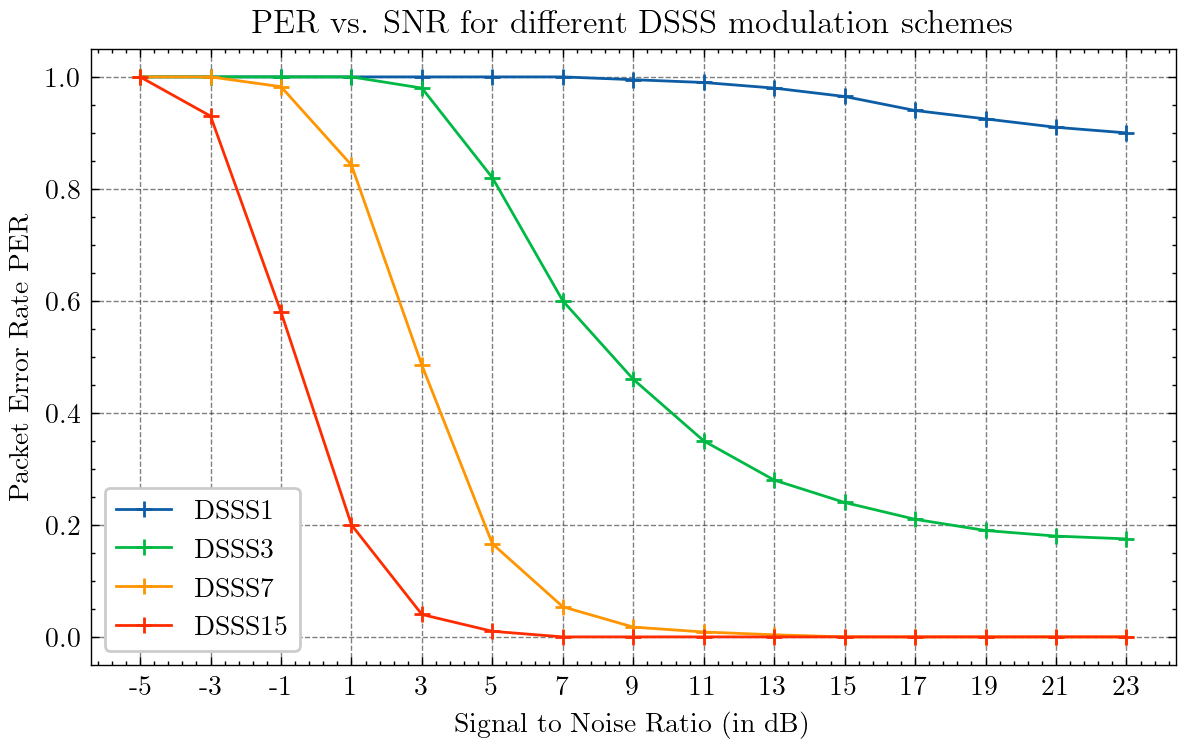

In [84]:
plt.figure(figsize=(7,4), dpi=200)
for k in range(4) :
    plt.plot(df_per['SNR'], df_per['TEP_' + labels[k]], label = labels[k], marker = "+")
plt.xlabel("Signal to Noise Ratio (in dB)")
plt.ylabel("Packet Error Rate PER")
plt.legend(loc="best")
plt.title("PER vs. SNR for different DSSS modulation schemes")

In [85]:
# PER and bitrates for each modulation method
per_values = df[str(C_SNR_DB)].to_numpy()
print("Selected Packet Error Rate values :", per_values)
# Birates
bitrates = np.array([2520, 840, 360, 168])

Selected Packet Error Rate values : [0.99    0.35    0.00875 0.     ]


# 2. Python implementatio of the Q-Learning agent 

In [86]:
def get_action(Q, eps):
    """Perform an epsilon-greedy action selection.

    Parameters
    ----------
    Q: array-like
        Estimated action values
    eps: float
        Probability of selecting a non-greedy action instead of the greedy one

    Returns
    -------
    a: int
        An action
    """
    if np.random.random() <= eps:
        a = np.random.randint(Q.size)
    else:
        a = np.argmax(Q)
    return a

In [87]:
def get_reward(tep_values, a):
    """Return a reward according to the selected action and the data.

    Parameters
    ----------
    tep_values: array-like
        The error rates
    a: int
        The selected action

    Returns
    -------
    R: float
        A reward 
    """
    if np.random.random() < tep_values[a]:
        R = -1 # Non-transmitted packet
    else:
        R = 1
    return R 

In [88]:
def fit_mean_rewards(per_values, broken_modulations = None, jump_times = None, n_agents=1000, n_iter=1000, eps=.05, alpha = None):
    """Train the agent using incrementally computed sample averages and
    epsilon-greedy action selection.

    Parameters
    ----------
   
    per_values: array-like
        TEP values of each modulation method
    broken_modulation: list of array-like
        indices of broken modulation schemes at each time jump
    jump_times: array-like
        times at which available modulation schemes change
    n_iter: int, default 1000
        Number of time steps
    n_agent: int, default 1000
        Number of agents
    eps: float, default 0.05
        Probability of selecting a non-greedy action instead of the greedy one
    alpha: float, 
        Learning rate, if set to None, the sample-average method is used: 
        the learning rate is set to 1 / number of times action a has been chosen 
        between first and current iteration
        
    Returns
    -------
    mean_rewards: list(float)
        Mean reward at each time step
    """

    # Number of actions ie number of modulation methods
    k = per_values.size 
    Q = np.zeros((n_iter + 1, n_agents, k))
    # Estimated action values for each agent
    N = np.zeros((n_agents, k)) 
    # Number of action selections for each agent
    rewards = np.zeros((n_iter, n_agents))
    # Save the base PER values
    old_per_values = per_values
    
    if jump_times is not None :
        jump_index = 0
    
    for n_iter_current in range(n_iter) :

        # Non-stationarity: some modulation schemes are disabled
        # at given times
        if ((jump_times is not None) 
        and (n_iter_current <= jump_times[-1]) 
        and (n_iter_current == jump_times[jump_index])) :
            # Restore the base PER values
            per_values = old_per_values.copy()
            # Disable some modulations
            per_values[broken_modulations[jump_index]] = 1.
            jump_index += 1

        # Iter through every agents
        for n_agent_current in range(n_agents):
            
            # Get next action
            a = get_action(Q[n_iter_current, n_agent_current, :], eps)
            # Get the corresponding reward
            R = get_reward(per_values, a)
            # Update the action count
            N[n_agent_current, a] += 1
            
            # If alpha is set to None, the learning-rate is set to
            # 1 / number of times action a has been chosen between first 
            # and current iteration
            if alpha is None :
                alpha = 1 / N[n_agent_current, a] 

            # Update of the action-value estimate for the selected action
            Q[n_iter_current + 1 : , n_agent_current, a] =\
                 Q[n_iter_current, n_agent_current, a] +\
                    alpha * (R - Q[n_iter_current, n_agent_current, a])

            # Update the mean reward
            rewards[n_iter_current, n_agent_current] = R

    return rewards, Q

In [89]:
def fit_total_reward(bitrates, tep_values, n_iter=1000, eps=0.05):
    """Train the agent using incrementally computed sample averages and
    epsilon-greedy action selection.

    Parameters
    ----------
    bitrates: array-like
        Bitrate (in bits/s) of each modulation method
    tep_values: array-like
        TEP values of each modulation method
    n_iter: int, default 100
        Number of iterations
    eps: float, default 0.05
        Probability of selecting a non-greedy action instead of the greedy one

    Returns
    -------
    total_reward: float
        The total reward. It is the sum of the bitrates used during the run.
    """
    k = bitrates.size # Number of actions ie number of modulation methods
    Q = np.zeros(k) # Estimated action values
    N = np.zeros(k) # Number of times each action was chosen
    total_reward = 0
    
    for _ in range(n_iter):
        # Select an action and add the corresponding reward
        a = get_action(Q, eps)
        R = get_reward(tep_values, a)
        total_reward += R

        # Update of action value using sample-average method
        N[a] += 1
        Q[a] += (R - Q[a]) / N[a]

    return total_reward

# 3. Influence of $\varepsilon$ on the total reward

In [90]:
# Experience parameters
eps_range = np.logspace(-4, 0, 10)
total_rewards = np.array([])

# Compute the total reward for each epsilon
for eps in tqdm(eps_range):
    
    rewards, _ = fit_mean_rewards(per_values, n_agents=C_N_AGENTS, n_iter=C_N_ITER, eps=eps, alpha = C_LEARNING_RATE)
    total_reward = np.mean(np.sum(rewards, axis = 0))
    total_rewards = np.concatenate((total_rewards, np.array([total_reward])))

100%|██████████| 10/10 [01:04<00:00,  6.47s/it]


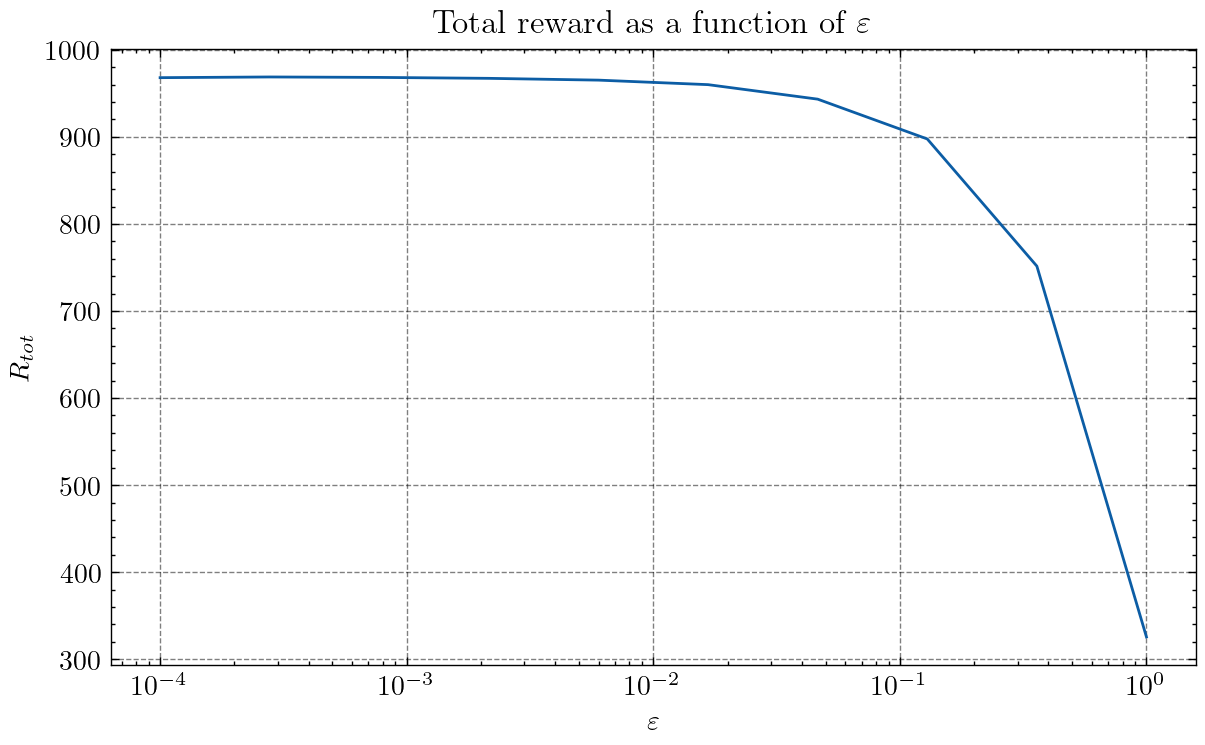

In [91]:
# Plot total_reward = f(epsilon)

plt.figure(figsize=(7,4), dpi=200)
plt.semilogx(eps_range, total_rewards)
plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$R_{tot}$')
plt.title(r'Total reward as a function of $\varepsilon$')
plt.show()

In [92]:
print(f"Optimal computed epsilon: {eps_range[np.argmax(total_rewards)]:.3f}")

Optimal computed epsilon: 0.000


**Observations:**
- Neither the greedy selection method (i.e. $\varepsilon=0$) nor the random selection method (i.e. $\varepsilon=1$) are the optimal ones. A small value of $\varepsilon$ like $\varepsilon=0.05$ leads to better results in terms of total reward.
- Because of the absence of exploration, the greedy action selection method seems worse than the random one.
- The overall trend shows that total reward decreases as $\varepsilon$ increases. So it seems that exploration should be restricted and negligible compared to exploitation.

# 4. Average cumulative reward in the stationary case

In [93]:
# Reset the seed
np.random.seed(1)
# Compute the mean rewards for different epsilons
epsilons = [0, 1e-2, 5e-2, 1e-1]
# Compute the mean rewards for different epsilons
epsilons = [0, 1e-2, 5e-2, 1e-1]
rewards_stat_list = list()
per_stat_list = list()
jump_times = [300, 600]
broken_modulations = [[2, 3], [3]]

for eps in epsilons:

    # Get rewards and estimated TEP
    rewards_stat, per_stat = fit_mean_rewards(per_values, n_agents=C_N_AGENTS, n_iter=C_N_ITER, eps=eps, alpha=C_LEARNING_RATE)
    rewards_stat_list.append(rewards_stat)
    per_stat_list.append(per_stat)

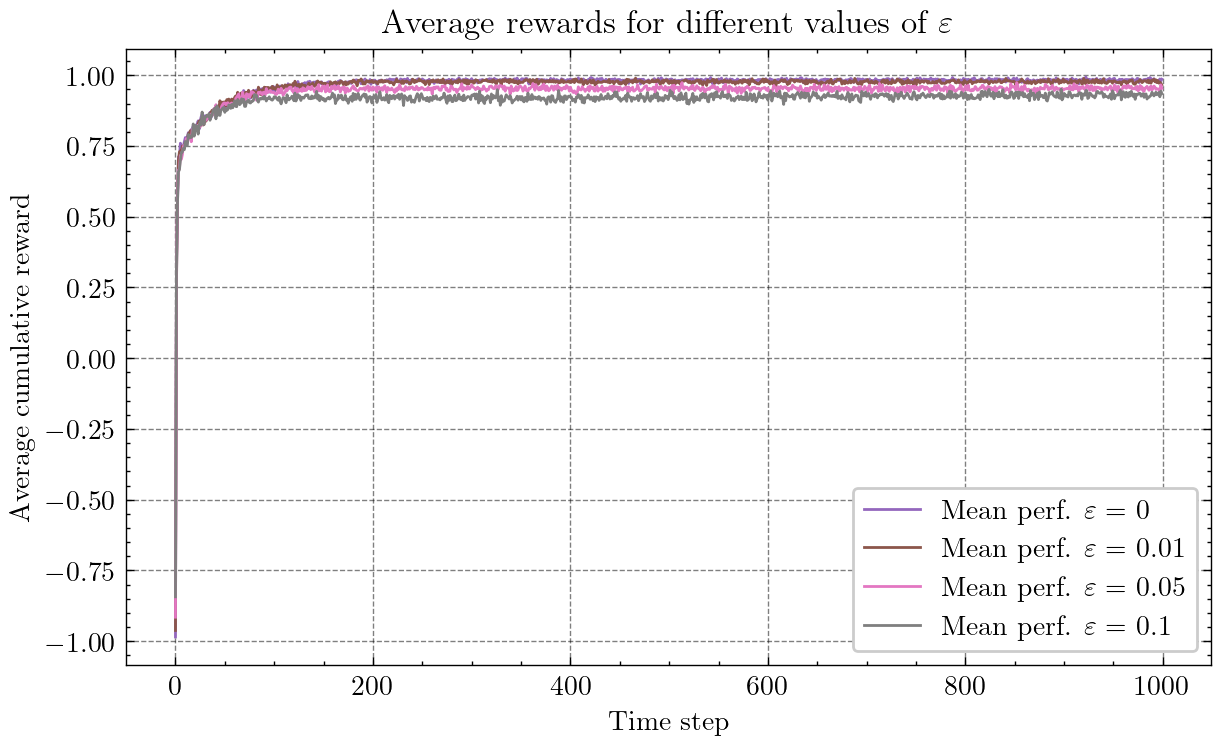

In [94]:
plt.figure(figsize=(7,4), dpi=200)
plt.plot(np.mean(rewards_stat_list[0], axis = 1), label=r'Mean perf. $\varepsilon=$ ' + f'{epsilons[0]}', color = "tab:purple")
plt.plot(np.mean(rewards_stat_list[1], axis = 1), label=r'Mean perf. $\varepsilon=$ ' + f'{epsilons[1]}', color = "tab:brown")
plt.plot(np.mean(rewards_stat_list[2], axis = 1), label=r'Mean perf. $\varepsilon=$ ' + f'{epsilons[2]}', color = "tab:pink")
plt.plot(np.mean(rewards_stat_list[3], axis = 1), label=r'Mean perf. $\varepsilon=$ ' + f'{epsilons[3]}', color = "tab:gray")
plt.title(r'Average rewards for different values of $\varepsilon$')
plt.xlabel('Time step')
plt.ylabel('Average cumulative reward')
plt.legend()
plt.show()

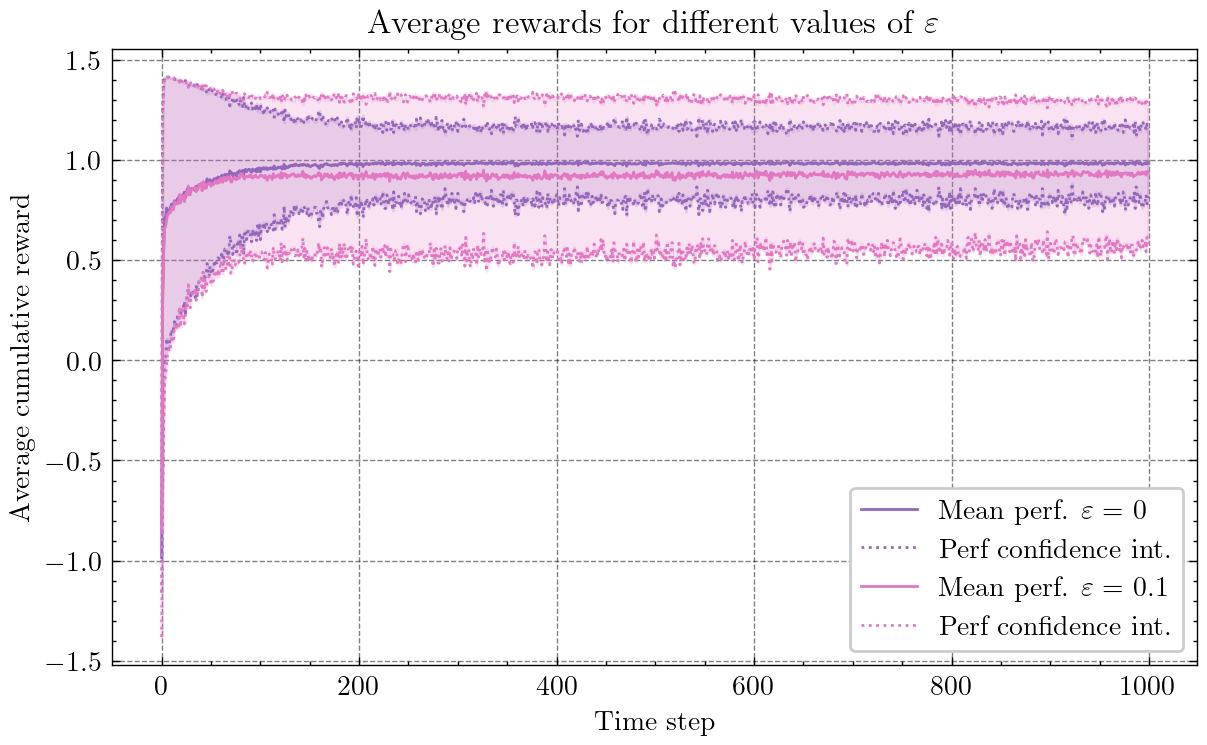

In [95]:
plt.figure(figsize=(7,4), dpi=200)

# Greedy 
plt.plot(np.mean(rewards_stat_list[0], axis = 1), label=r'Mean perf. $\varepsilon=$ ' + f'{epsilons[0]}', color = "tab:purple")
plt.fill_between(np.arange(0, rewards_stat_list[0].shape[0], 1), np.mean(rewards_stat_list[0], axis = 1) + np.std(rewards_stat_list[0], axis = 1), np.mean(rewards_stat_list[0], axis = 1) - np.std(rewards_stat_list[0], axis = 1), alpha=0.2, color = "tab:purple")
plt.plot(np.mean(rewards_stat_list[0], axis = 1) + np.std(rewards_stat_list[0], axis = 1), color = "tab:purple", linestyle="dotted", label = "Perf confidence int.")
plt.plot(np.mean(rewards_stat_list[0], axis = 1) - np.std(rewards_stat_list[0], axis = 1), color = "tab:purple", linestyle="dotted")

# Epsilon greedy with epsilon = .05
plt.plot(np.mean(rewards_stat_list[3], axis = 1), label=r'Mean perf. $\varepsilon=$ ' + f'{epsilons[3]}', color = "tab:pink")
plt.fill_between(np.arange(0, rewards_stat_list[3].shape[0], 1), np.mean(rewards_stat_list[3], axis = 1) + np.std(rewards_stat_list[3], axis = 1), np.mean(rewards_stat_list[3], axis = 1) - np.std(rewards_stat_list[3], axis = 1), alpha=0.2, color = "tab:pink")
plt.plot(np.mean(rewards_stat_list[3], axis = 1) + np.std(rewards_stat_list[3], axis = 1), color = "tab:pink", linestyle="dotted", label = "Perf confidence int.")
plt.plot(np.mean(rewards_stat_list[3], axis = 1) - np.std(rewards_stat_list[3], axis = 1), color = "tab:pink", linestyle="dotted")

plt.title(r'Average rewards for different values of $\varepsilon$')
plt.xlabel('Time step')
plt.ylabel('Average cumulative reward')
plt.legend()
plt.show()

# 5. Average cumulative reward in the non-stationary case

In [96]:
# Reset the seed
np.random.seed(1)
# Compute the mean rewards for different epsilons
epsilons = [0, 1e-2, 5e-2, 1e-1]
rewards_non_stat_list = list()
per_non_stat_list = list()
jump_times = [300, 600]
broken_modulations = [[2, 3], [3]]

for eps in epsilons:

    # Get rewards and estimated TEP
    rewards_non_stat, per_non_stat = fit_mean_rewards(per_values, broken_modulations = broken_modulations, jump_times = jump_times, n_agents= C_N_AGENTS, n_iter = C_N_ITER, eps = eps, alpha=C_LEARNING_RATE)
    rewards_non_stat_list.append(rewards_non_stat)
    per_non_stat_list.append(per_non_stat)

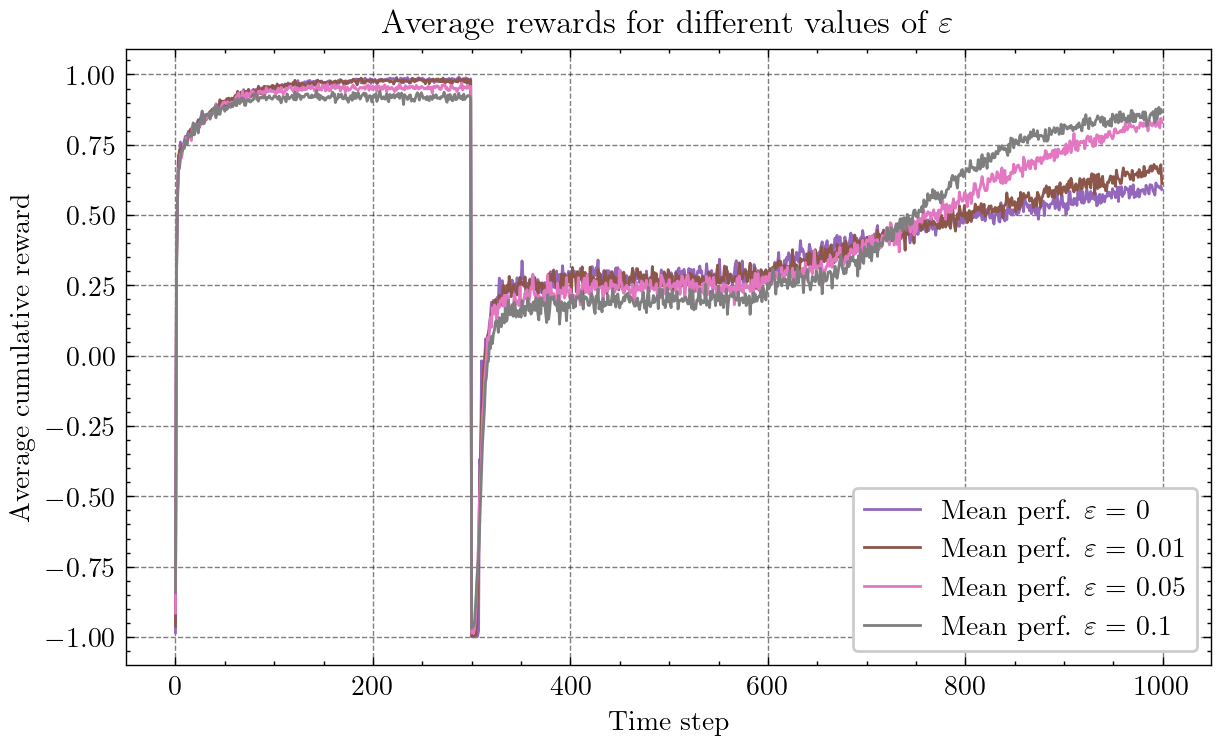

In [97]:
plt.figure(figsize=(7,4), dpi=200)
plt.plot(np.mean(rewards_non_stat_list[0], axis = 1), label=r'Mean perf. $\varepsilon=$ ' + f'{epsilons[0]}', color = "tab:purple")
plt.plot(np.mean(rewards_non_stat_list[1], axis = 1), label=r'Mean perf. $\varepsilon=$ ' + f'{epsilons[1]}', color = "tab:brown")
plt.plot(np.mean(rewards_non_stat_list[2], axis = 1), label=r'Mean perf. $\varepsilon=$ ' + f'{epsilons[2]}', color = "tab:pink")
plt.plot(np.mean(rewards_non_stat_list[3], axis = 1), label=r'Mean perf. $\varepsilon=$ ' + f'{epsilons[3]}', color = "tab:gray")
plt.title(r'Average rewards for different values of $\varepsilon$')
plt.xlabel('Time step')
plt.ylabel('Average cumulative reward')
plt.legend()
plt.show()

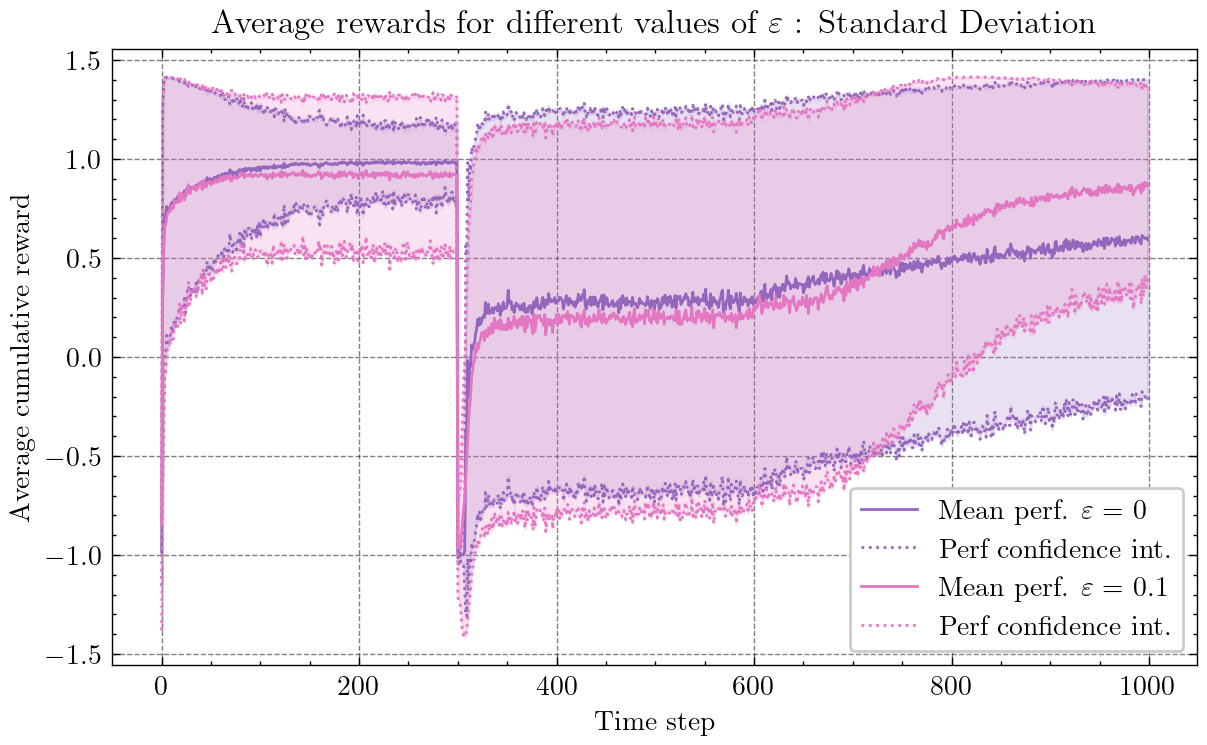

In [98]:
plt.figure(figsize=(7,4), dpi=200)

# Greedy 
plt.plot(np.mean(rewards_non_stat_list[0], axis = 1), label=r'Mean perf. $\varepsilon=$ ' + f'{epsilons[0]}', color = "tab:purple")
plt.fill_between(np.arange(0, rewards_non_stat_list[0].shape[0], 1), np.mean(rewards_non_stat_list[0], axis = 1) + np.std(rewards_non_stat_list[0], axis = 1), np.mean(rewards_non_stat_list[0], axis = 1) - np.std(rewards_non_stat_list[0], axis = 1), alpha=0.2, color = "tab:purple")
plt.plot(np.mean(rewards_non_stat_list[0], axis = 1) + np.std(rewards_non_stat_list[0], axis = 1), color = "tab:purple", linestyle="dotted", label = "Perf confidence int.")
plt.plot(np.mean(rewards_non_stat_list[0], axis = 1) - np.std(rewards_non_stat_list[0], axis = 1), color = "tab:purple", linestyle="dotted")

# Epsilon greedy with epsilon = .05
plt.plot(np.mean(rewards_non_stat_list[3], axis = 1), label=r'Mean perf. $\varepsilon=$ ' + f'{epsilons[3]}', color = "tab:pink")
plt.fill_between(np.arange(0, rewards_non_stat_list[3].shape[0], 1), np.mean(rewards_non_stat_list[3], axis = 1) + np.std(rewards_non_stat_list[3], axis = 1), np.mean(rewards_non_stat_list[3], axis = 1) - np.std(rewards_non_stat_list[3], axis = 1), alpha=0.2, color = "tab:pink")
plt.plot(np.mean(rewards_non_stat_list[3], axis = 1) + np.std(rewards_non_stat_list[3], axis = 1), color = "tab:pink", linestyle="dotted", label = "Perf confidence int.")
plt.plot(np.mean(rewards_non_stat_list[3], axis = 1) - np.std(rewards_non_stat_list[3], axis = 1), color = "tab:pink", linestyle="dotted")

plt.title(r'Average rewards for different values of $\varepsilon$ : Standard Deviation')
plt.xlabel('Time step')
plt.ylabel('Average cumulative reward')
plt.legend()
plt.show()

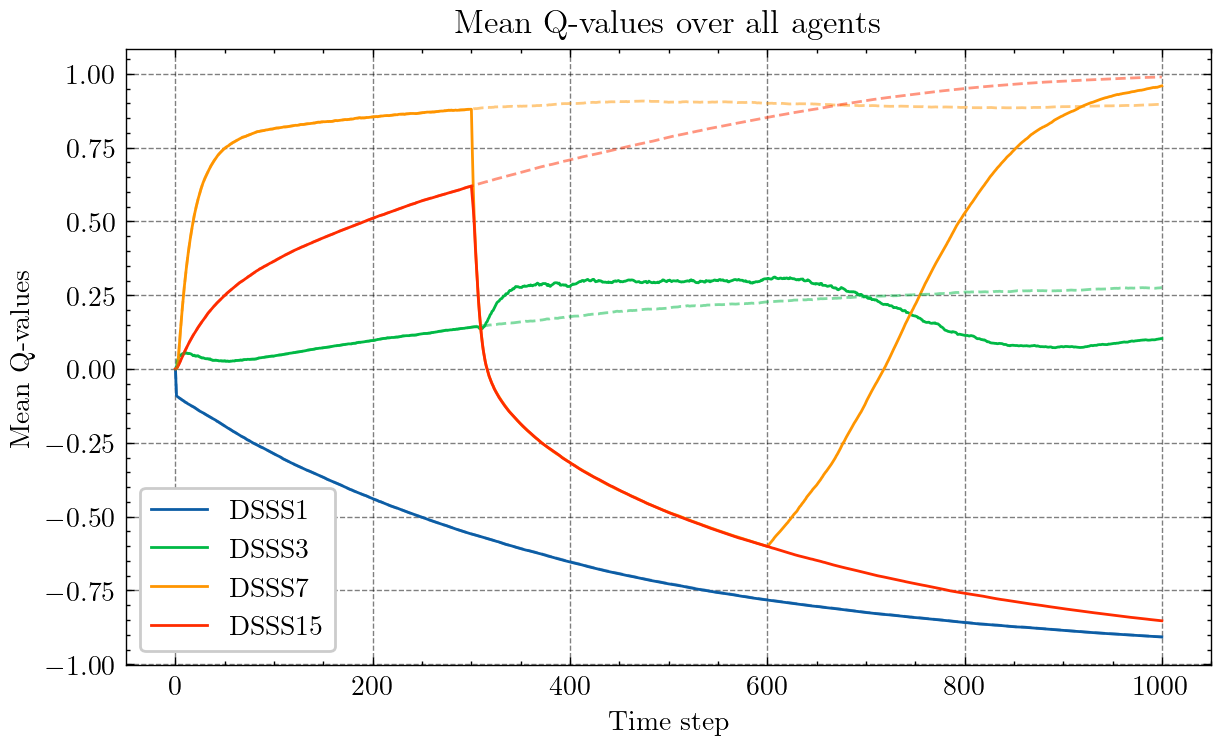

In [99]:
plt.figure(figsize=(7,4), dpi=200)
plt.plot(np.mean(per_non_stat_list[3][:, :, :], axis = 1), label = labels)
plt.gca().set_prop_cycle(None)
plt.plot(np.mean(per_stat_list[3][:, :, :], axis = 1), linestyle = "dashed", alpha = 0.5)
plt.legend(loc="best")
plt.xlabel('Time step')
plt.ylabel('Mean Q-values')
plt.legend()
plt.title("Mean Q-values over all agents")
plt.show()

Text(0.5, 1.0, "Agent's 42 Q-values")

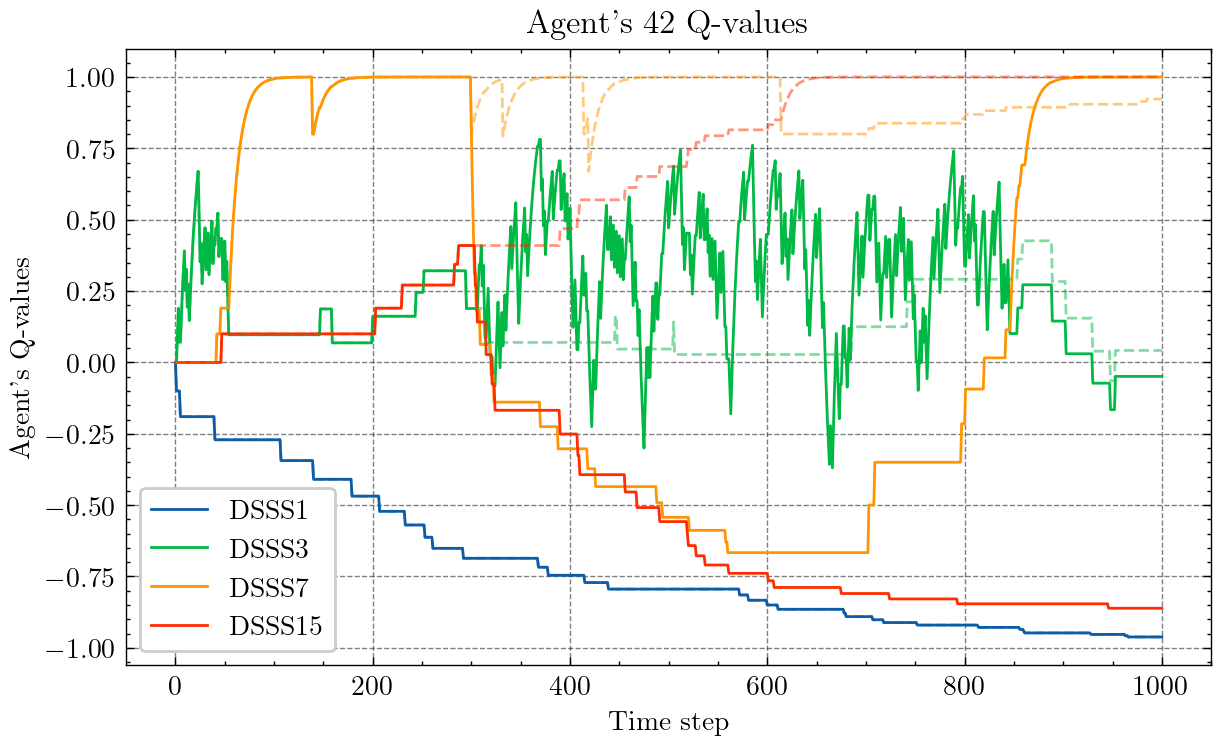

In [100]:
plt.figure(figsize=(7,4), dpi=200)
plt.plot(per_non_stat_list[3][:, 42, :], label = labels)
plt.gca().set_prop_cycle(None)
plt.plot(per_stat_list[3][:, 42, :], linestyle = "dashed", alpha = 0.5)
plt.legend(loc="best")
plt.xlabel('Time step')
plt.ylabel("Agent's Q-values")
plt.title("Agent's 42 Q-values")

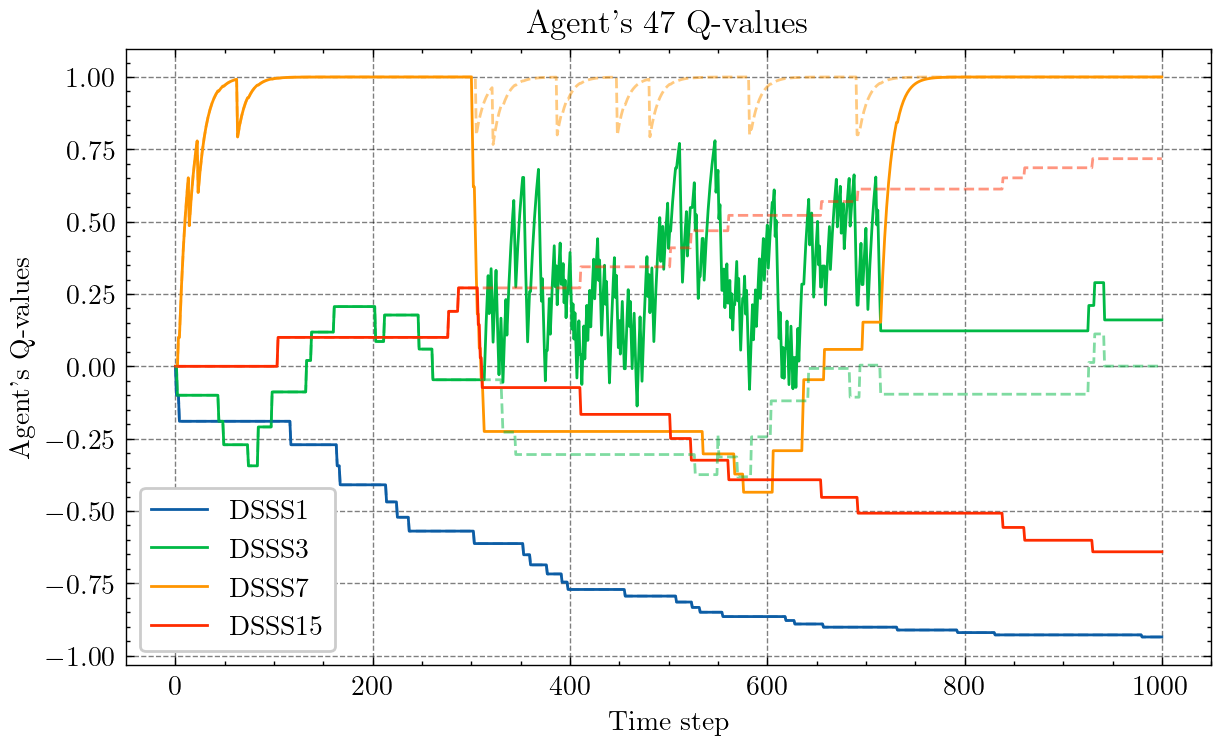

In [101]:
plt.figure(figsize=(7,4), dpi=200)
plt.plot(per_non_stat_list[3][:, 47, :], label = labels)
plt.gca().set_prop_cycle(None)
plt.plot(per_stat_list[3][:, 47, :], linestyle = "dashed", alpha = 0.5)
plt.legend(loc="best")
plt.xlabel('Time step')
plt.ylabel("Agent's Q-values")
plt.legend()
plt.title("Agent's 47 Q-values")
plt.show()